In [14]:
import keras
import data_loader
import numpy as np
import pandas as pd
import scikitplot as skplt
import matplotlib.pyplot as plt

tokenized_corpus = 'corpus.tk.txt'
trained_word_vector = 'corpus.tk.vec.txt'
score_corpus = 'score_corpus.txt'
            
loader = data_loader.DataLoader(tokenized_corpus, trained_word_vector, score_corpus)
loader.load_data()

x_train, y_train = loader.train
x_test, y_test = loader.test

number of unique tokens: 12000
x_train: (26080, 30) / y_train: (26080, 10)
x_test: (6521, 30) / y_test: (6521, 10)
number of trained word vector: 17117
embedding matrix shape: (12001, 300)


In [34]:
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Dropout, Concatenate, Flatten, Dense
from keras.models import Model
from keras.initializers import Constant

inputs = Input(shape=(loader.max_corpus_len,), dtype='int32')
embedding = Embedding(loader.max_word_num+1, loader.embedding_dim,
                     embeddings_initializer = Constant(loader.embedding_matrix),
                     input_length=loader.max_corpus_len, trainable=False)(inputs)

stacks = []
for kernel_size in [2, 3, 4]:
    conv = Conv1D(64, kernel_size, padding='same', activation='relu', strides=1)(embedding)
    pool = MaxPooling1D(pool_size=3)(conv)
    drop = Dropout(0.5)(pool)
    stacks.append(drop)
    
merged = Concatenate()(stacks)
flatten = Flatten()(merged)
drop = Dropout(0.5)(flatten)
outputs = Dense(y_train.shape[1], activation='softmax')(drop)

model = Model(inputs, outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 30, 300)      3600300     input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 30, 64)       38464       embedding_7[0][0]                
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 30, 64)       57664       embedding_7[0][0]                
__________________________________________________________________________________________________
conv1d_15 

In [35]:
hist = model.fit(x_train, y_train,
                epochs=30, batch_size=64,
                validation_data=(x_test, y_test), verbose=2)

Train on 26080 samples, validate on 6521 samples
Epoch 1/30
 - 12s - loss: 1.2015 - acc: 0.6867 - val_loss: 1.1083 - val_acc: 0.6935
Epoch 2/30
 - 3s - loss: 1.1092 - acc: 0.6931 - val_loss: 1.0874 - val_acc: 0.6930
Epoch 3/30
 - 3s - loss: 1.0885 - acc: 0.6928 - val_loss: 1.0746 - val_acc: 0.6938
Epoch 4/30
 - 3s - loss: 1.0679 - acc: 0.6942 - val_loss: 1.0816 - val_acc: 0.6935
Epoch 5/30
 - 3s - loss: 1.0473 - acc: 0.6948 - val_loss: 1.0659 - val_acc: 0.6938
Epoch 6/30
 - 3s - loss: 1.0388 - acc: 0.6942 - val_loss: 1.0626 - val_acc: 0.6942
Epoch 7/30
 - 3s - loss: 1.0226 - acc: 0.6968 - val_loss: 1.0538 - val_acc: 0.6948
Epoch 8/30
 - 3s - loss: 1.0100 - acc: 0.6967 - val_loss: 1.0522 - val_acc: 0.6951
Epoch 9/30
 - 3s - loss: 1.0006 - acc: 0.6967 - val_loss: 1.0477 - val_acc: 0.6958
Epoch 10/30
 - 3s - loss: 0.9862 - acc: 0.7000 - val_loss: 1.0453 - val_acc: 0.6967
Epoch 11/30
 - 3s - loss: 0.9768 - acc: 0.7012 - val_loss: 1.0656 - val_acc: 0.6950
Epoch 12/30
 - 3s - loss: 0.9634 - 

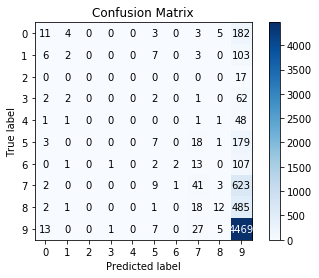

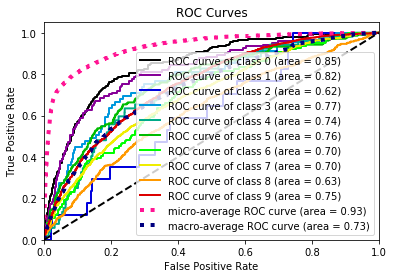

In [44]:
pred = model.predict(x_test)
skplt.metrics.plot_confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred, axis=1))
skplt.metrics.plot_roc(np.argmax(y_test, axis=1), pred)

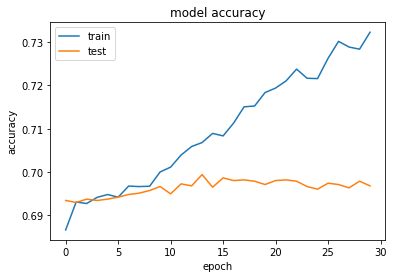

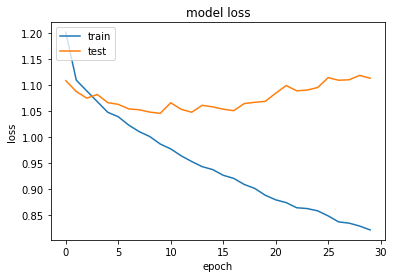

In [46]:
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()